# Predict Cuisine from Key Words

## Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import os
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import re
import time
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem import PorterStemmer
ps = PorterStemmer()

sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Dataset

In [9]:
df = pd.read_json('train.json')
df['cuisine_name'] = df['cuisine']
df.drop(columns=['id', 'cuisine'], inplace=True)
display(df.head(20))
print('number of data points: ', len(df))

,ingredients,cuisine_name
0,"[romaine lettuce, black olives, grape tomatoes...",greek
1,"[plain flour, ground pepper, salt, tomatoes, g...",southern_us
2,"[eggs, pepper, salt, mayonaise, cooking oil, g...",filipino
3,"[water, vegetable oil, wheat, salt]",indian
4,"[black pepper, shallots, cornflour, cayenne pe...",indian
5,"[plain flour, sugar, butter, eggs, fresh ginge...",jamaican
6,"[olive oil, salt, medium shrimp, pepper, garli...",spanish
7,"[sugar, pistachio nuts, white almond bark, flo...",italian
8,"[olive oil, purple onion, fresh pineapple, por...",mexican
9,"[chopped tomatoes, fresh basil, garlic, extra-...",italian


number of data points:  39774


## Filter out 'Stop Words', remove symbols, Porter-Stemmer

In [10]:
stop_words = set(stopwords.words('english'))
new_ingredients = []
for recipe in df.ingredients:
    filtered_recipe = []
    for ingredient in recipe:
        # Filter with RegEx
        ingredient=ingredient.split('\u2122', 1)[-1]
        ingredient=ingredient.split('\u00AE', 1)[-1]
        ingredient = re.sub(r'[^\w\s]', '', ingredient)
        ingredient=re.sub(r"(\d)", "", ingredient)
        ingredient=re.sub(r'\([^)]*\)', '', ingredient)
        ingredient = ingredient.lower()
        tokenized_ingredient = word_tokenize(ingredient)
        new_ingredient = []
        for word in tokenized_ingredient:
            if word not in stop_words:
                new_ingredient.append(ps.stem(word))
        filtered_recipe.append(' '.join(new_ingredient))
    new_ingredients.append(filtered_recipe)
df['new_ingredients'] = new_ingredients

## Obtain All Unique Words and their Counts

In [11]:
all_ingredients = np.concatenate(tuple(df.new_ingredients.values[i] for i in range(len(df.new_ingredients.values))))
words = word_tokenize(' '.join(all_ingredients))
unique_words, counts = np.unique(words, return_counts=True)
print('unique words: ', unique_words)
print('num unique words: ', len(unique_words))
print('counts: ', counts)

unique words:  ['abalon' 'abbamel' 'absinth' ... 'ziti' 'zucchini' 'épice']
num unique words:  2649
counts:  [  2   1   1 ...  38 931   4]


## Sort Ingredients by Largest Occurrence

In [12]:
highest_count_indices = np.argsort(counts)
highest_counts = np.flip(counts[highest_count_indices])
most_unique_words = np.flip(unique_words[highest_count_indices])
print(highest_counts)
print(most_unique_words)

[27189 24625 23323 ...     1     1     1]
['pepper' 'salt' 'oil' ... 'orgeat' 'orient' 'petral']


## Create New Column with Ingredients Separated by Whitespace

In [13]:
df['spaced_ingredients'] = df['new_ingredients'].apply(lambda x: ' '.join(x))
df['tokenized_words'] = df['spaced_ingredients'].apply(word_tokenize)
display(df)

,ingredients,cuisine_name,new_ingredients,spaced_ingredients,tokenized_words
0,"[romaine lettuce, black olives, grape tomatoes...",greek,"[romain lettuc, black oliv, grape tomato, garl...",romain lettuc black oliv grape tomato garlic p...,"[romain, lettuc, black, oliv, grape, tomato, g..."
1,"[plain flour, ground pepper, salt, tomatoes, g...",southern_us,"[plain flour, ground pepper, salt, tomato, gro...",plain flour ground pepper salt tomato ground b...,"[plain, flour, ground, pepper, salt, tomato, g..."
2,"[eggs, pepper, salt, mayonaise, cooking oil, g...",filipino,"[egg, pepper, salt, mayonais, cook oil, green ...",egg pepper salt mayonais cook oil green chili ...,"[egg, pepper, salt, mayonais, cook, oil, green..."
3,"[water, vegetable oil, wheat, salt]",indian,"[water, veget oil, wheat, salt]",water veget oil wheat salt,"[water, veget, oil, wheat, salt]"
4,"[black pepper, shallots, cornflour, cayenne pe...",indian,"[black pepper, shallot, cornflour, cayenn pepp...",black pepper shallot cornflour cayenn pepper o...,"[black, pepper, shallot, cornflour, cayenn, pe..."
...,...,...,...,...,...
39769,"[light brown sugar, granulated sugar, butter, ...",irish,"[light brown sugar, granul sugar, butter, warm...",light brown sugar granul sugar butter warm wat...,"[light, brown, sugar, granul, sugar, butter, w..."
39770,"[KRAFT Zesty Italian Dressing, purple onion, b...",italian,"[kraft zesti italian dress, purpl onion, brocc...",kraft zesti italian dress purpl onion broccoli...,"[kraft, zesti, italian, dress, purpl, onion, b..."
39771,"[eggs, citrus fruit, raisins, sourdough starte...",irish,"[egg, citru fruit, raisin, sourdough starter, ...",egg citru fruit raisin sourdough starter flour...,"[egg, citru, fruit, raisin, sourdough, starter..."
39772,"[boneless chicken skinless thigh, minced garli...",chinese,"[boneless chicken skinless thigh, minc garlic,...",boneless chicken skinless thigh minc garlic st...,"[boneless, chicken, skinless, thigh, minc, gar..."


## Create One-hot Encoded Dataframe with all ~3021 Words

In [14]:
mlb = MultiLabelBinarizer()
one_hot_df = pd.DataFrame(mlb.fit_transform(df['tokenized_words']),columns=mlb.classes_, index=df.cuisine_name)[most_unique_words]
one_hot_df['index_col'] = range(0, len(df), 1)
one_hot_df = one_hot_df.reset_index().set_index('index_col')
display(one_hot_df)

,cuisine_name,pepper,salt,oil,onion,garlic,ground,fresh,sauc,sugar,...,colorado,colaflavor,oli,colman,opo,orchid,coldsmok,orgeat,orient,petral
index_col,,,,,,,,,,,,,,,,,,,,,
0,greek,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,irish,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
39770,italian,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,irish,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Create Training/Testing Data Split

In [15]:
X = one_hot_df.iloc[:, 1:]
y = one_hot_df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

### Find Optimal Number of Neighbors

In [16]:
kfold = StratifiedKFold(5, shuffle=True, random_state=10)
max_neighbors = 30
knn_accs = np.zeros((5, max_neighbors))
i = 0
for train_index, test_index in kfold.split(X_train, y_train.values):
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    j = 0
    for k in range(1,max_neighbors+1):
        knn = KNeighborsClassifier(k)
        knn.fit(X_tt.iloc[:, :900].values, y_tt.values)
        
        pred = knn.predict(X_ho.iloc[:, :900].values)
        
        knn_accs[i,j] = accuracy_score(y_ho.values, pred)
        j = j + 1
    i = i + 1

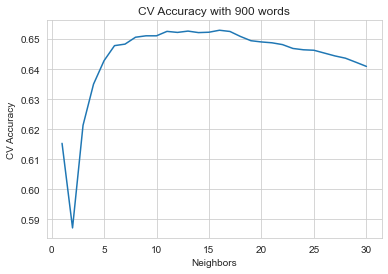

Highest Accuracy:  0.6529  with  15  neighbors


In [17]:
accuracies = np.mean(knn_accs, axis=0)
plt.figure()
plt.plot(np.arange(1, max_neighbors+1, 1), accuracies)
plt.xlabel('Neighbors')
plt.ylabel('CV Accuracy')
plt.title('CV Accuracy with 900 words')
plt.savefig('neighbors_comp.png')
plt.show()
print('Highest Accuracy: ', np.round(np.max(accuracies), 4), ' with ', np.argmax(accuracies), ' neighbors')

#### Let's pick k = 11, that looks like first peak

### Find Optimal Number of Words

In [20]:
kfold = StratifiedKFold(5, shuffle=True, random_state=10)
num_ingredients = np.arange(100, 2600, 100)
ing_accs = np.zeros((5, len(num_ingredients)))
i = 0
start_time = time.time()
for train_index, test_index in kfold.split(X_train, y_train.values):
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    j = 0
    for k in num_ingredients:
        knn = KNeighborsClassifier(11)
        knn.fit(X_tt.iloc[:, :k].values, y_tt.values)
        
        pred = knn.predict(X_ho.iloc[:, :k].values)
        
        ing_accs[i,j] = accuracy_score(y_ho.values, pred)
        j = j + 1
    i = i + 1
end_time = time.time()

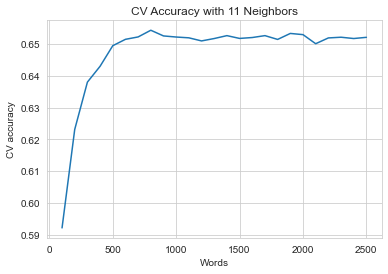

it took  12.683  minutes to run the CV
Highest Accuracy:  0.6544  with  800  ingredients


In [21]:
accuracies = np.mean(ing_accs, axis=0)
plt.figure()
plt.plot(num_ingredients, accuracies)
plt.xlabel('Words')
plt.title('CV Accuracy with 11 Neighbors')
plt.ylabel('CV accuracy')
plt.savefig('words_comp.png')
plt.show()
print('it took ', round((end_time-start_time)/60, 3), ' minutes to run the CV')
print('Highest Accuracy: ', np.round(np.max(accuracies), 4), ' with ', num_ingredients[np.argmax(accuracies)], ' ingredients')


#### Looks like 11 Neighbors and 800 words gives good results without overfitting. Now, we can test this model on the testing data set.

## Cross-Validation Statistics

In [22]:
kfold = StratifiedKFold(5, shuffle=True, random_state=10)
ing_accs = np.zeros(5)
ing_precs = np.zeros(5)
ing_recalls = np.zeros(5)
i = 0
start_time = time.time()
for train_index, test_index in kfold.split(X_train, y_train.values):
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    knn = KNeighborsClassifier(12)
    knn.fit(X_tt.iloc[:, :900].values, y_tt.values)
    pred = knn.predict(X_ho.iloc[:, :900].values)
    ing_accs[i] = accuracy_score(y_ho.values, pred)
    ing_precs[i] = precision_score(y_ho.values, pred, average='macro')
    ing_recalls[i] = recall_score(y_ho.values, pred, average='macro')
    i = i + 1
end_time = time.time()

In [281]:
print('mean CV accuracy: ', np.mean(ing_accs))
print('mean CV precision: ', np.mean(ing_precs))
print('mean CV recall: ', np.mean(ing_recalls))
print('it took ', round((end_time-start_time)/60, 3), ' minutes to run the CV')

mean CV accuracy:  0.652220459991586
mean CV precision:  0.6318296484937125
mean CV recall:  0.5070402114780034


## Test Set Prediction

In [283]:
knn = KNeighborsClassifier(12)
knn.fit(X_train.iloc[:, :900].values, y_train.values)
pred = knn.predict(X_test.iloc[:, :900].values)
print('testing set accuracy: ', accuracy_score(y_test.values, pred))
print('testing set precision (macro): ', precision_score(y_test.values, pred, average='macro'))
print('testing set recall (macro): ', recall_score(y_test.values, pred, average='macro'))
print('testing set f1 score (macro): ', f1_score(y_test.values, pred, average='macro'))
#print('testing set precision (micro): ', precision_score(y_test.values, pred, average='micro'))
#print('testing set recall (micro): ', recall_score(y_test.values, pred, average='micro'))

testing set accuracy:  0.6629792583280956
testing set precision (macro):  0.6402267352560123
testing set recall (macro):  0.5158545152443497
testing set f1 score (macro):  0.5518313747353913


In [287]:
X_train, X_test, y_train, y_test = train_test_split(df['ingredients'], df['cuisine_name'], test_size=0.2, random_state=10, stratify=y)

## Baseline Model: Predict everything as Italian

### Train/Test Split is Stratified by cuisine type, so both have the same 19.7% accuracy

In [293]:
y_test.value_counts()['italian']/sum(y_test.value_counts().values)

0.19710873664362036